In [2]:
import nltk
import os, os.path
import pandas as pd
import glob
import re
import numpy as np

# import python module to clean transcripts
from subtitle_lib.srt_formatting import *

In [175]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Identifying Themes in Bourdain's "Parts Unknown": Topic Modeling and Clustering Televsion Transcripts

And also planning my next vacation...

“I usually try to avoid clean, orderly countries without massive social problems.”

## Data Aquisition

I downloaded transcripts of the television show "Parts Unknown" from [OpenSubtitles](https://www.opensubtitles.org) and from [CNN](http://www.cnn.com/TRANSCRIPTS/abpu.html). Unfortunately neither data source contained transcripts of all expisodes, so I needed to use both sources. . I considered using the CNN transcripts for the full project, but that data set was also incomplete and had more formatting issues than the open subtitles transcripts.

## Data Extraction and Formatting

My initial processing of transcripts from the two sources was tailored to the unique structure of the two transcript file types. For the OpenSubtitle files I processed with a modified script [here](https://gist.github.com/ndunn219/62263ce1fb59fda08656be7369ce329b) (modifications saved as the subtitle_lib module in this repo) and filtered the text to remove the intro theme song. For the CNN files, I used regex to remove narration indicators and a few common transcript words that appeared in this format.

After initial processing, both file types were combined into a data frame containing episode information and the full transcript text.

#### Data Extraction

In [26]:
# make list of full directory path names for each season

path = os.getcwd() + '/puk_data/'
dirs = os.listdir(path)
dirs.remove('.DS_Store')
dirs.remove('cnn_transcripts') # remove CNN transcripts from this processing step

full_dirs = []
for file in dirs:
    full_dir = path + file
    full_dirs.append(full_dir)

In [29]:
# make list of full episode path names for each episode of each season

episode_files = []
for file in full_dirs:
    contents = (glob.glob('{}/*'.format(file)))
    for episode in contents[:(len(contents))]:
        episode_srt = (glob.glob('{}/*'.format(episode)))
        episode_files.append(episode_srt[0])

In [5]:
# function to call cleaning scripts (from subtitle_lib.srt module) and write cleaned file as txt
# this function is for the open subtitles files in the .srt format

def clean_save_file(file_name):
    with open(file_name, encoding='utf-8', errors='replace') as f:
        lines = f.readlines()
        new_lines = clean_up(lines)
        new_file_name = 'processed_text/' + file_name[-28:-22] + '.txt'
        #print(new_file_name)
        with open(new_file_name, 'w') as f:
            for line in new_lines:
                f.write(line)

In [6]:
# call cleaning function on each episode, save to file

for episode in episode_files:
    clean_save_file(episode)

In [532]:
# cleaning function for transcripts from CNN (not open subtitles)

def clean_save_CNN_file(file_name):
    with open(file_name, encoding='utf-8', errors='replace') as f:
        lines = f.readlines()
        new_lines = clean_up(lines)
        new_file_name = 'processed_text/' + file_name[-10:]
        #print(new_file_name)
        with open(new_file_name, 'w') as f:
            for line in new_lines:
                f.write(line)

In [533]:
# make full file name of new episodes

CNN_episode_paths = []
for item in os.listdir(os.getcwd() + '/puk_data/cnn_transcripts/'):
    CNN_episode_paths.append((os.getcwd() + '/puk_data/cnn_transcripts/') +item)

# call CNN cleaning function for new episodes

for episode in CNN_episode_paths:
    clean_save_CNN_file(episode)

#### Saving Parsed Text Files to DF

In [534]:
# make list of full directory path names for each season

path = os.getcwd() + '/processed_text/'
files = os.listdir(path)
files.remove('.DS_Store') 
files.remove( '.480p..txt') # not sure what this file is, doesn't appear in file browser, removed
files.remove( '.S06E0.txt') # ditto

full_file_paths = [path + f for f in files] # create full file paths

In [535]:
# get subtitle text from each episode file

episode_list = [] # append tuple of episodeID and subtitle text to list

for f in full_file_paths:
    file = open(f, 'rU')
    episode_text = file.read()
    episode_name = (re.search(r'[ \w-]+?(?=\.)',f))[0]
    episode_info = (episode_name, episode_text)
    episode_list.append(episode_info)

/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 'U' mode is deprecated


In [536]:
# get CNN text from each CNN episode file

CNN_episode_list = [] # append tuple of episodeID and subtitle text to list

for f in CNN_episode_paths:
    file = open(f, 'rU')
    episode_text = file.read()
    episode_name = (re.search(r'[ \w-]+?(?=\.)',f))[0]
    episode_info = (episode_name, episode_text)
    CNN_episode_list.append(episode_info)

/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 'U' mode is deprecated


In [540]:
complete_episodes = episode_list

In [541]:
# append episodeID and subtitle text data to df
puk = pd.DataFrame.from_records(complete_episodes)
puk.columns=['episodeID', 'text']

#### Adding episode metadata to DF

In [1142]:
# read in csv with episode location information
episode_locations = pd.DataFrame.from_csv('puk_episode_list.csv',  index_col=None)

In [544]:
# merge location names into reviews df
puk = puk.merge(episode_locations, on='episodeID', how='left')

In [545]:
# convert str dates into date time objects 
puk.air_date = pd.to_datetime(puk.air_date)

#### Filtering episode text for a few common 'transcript words' and the theme song 

In [1530]:
# remove narration assignment from CNN transcripts and several common 'transcript' words

CNN_episodes = [x[:-4] for x in list(os.listdir(os.getcwd() + '/puk_data/cnn_transcripts/'))]

for episode in CNN_episodes:
    text = (puk.text[puk.episodeID==episode]).values[0]
    name_pattern = r'\b[A-Z0-9]{2,}\b'
    common_words = r'\W*(translator|voice-over|on camera|inaudible |speaking foreign language)\W*'
    first_search = re.sub(name_pattern,'',text)
    cleaned_text = re.sub(common_words,' ',first_search)
    puk.text[puk.episodeID==episode] = cleaned_text

/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [548]:
# funct to remove line containing a certain character

def remove_line(text, char):
    parsed_lines = []
    lines_tokens = nltk.sent_tokenize(text)
    for line in lines_tokens:
        if char not in line:
            keep_line = line
            parsed_lines.append(keep_line)
    text_str = '\n'.join(parsed_lines)
    return text_str

In [549]:
# remove theme song from subtitle text using the '♪' character

parsed_text = []

for idx,episode in puk.iterrows():
    text = episode.text
    text = remove_line(text, '♪')
    parsed_text.append(text)

puk['clean_text'] = parsed_text

In [550]:
# print a sample review
sample_episode = puk.iloc[33]
sample_episode = sample_episode.clean_text[0:296]

In [551]:
sample_episode

"One of our roles here has always been to take away excess money from people who don't know what to do with it, who can't think of a better idea about how to spend their money.\nIn the old days, you would throw it on a table.\nPut that in the context of throwing away a bottle of seven-up in a club."

## Testing tokenizers and stemmers

I tested out a few different tokenizers to see how they deal with the data. See some examples below. The nltk.word_tokenize() tokenizer does a reasonable job of splitting contractions (like 'can't' and 'don't') and identifying punctuation, so it was selected for intial analysis of this data.

In [552]:
#Various Tokenizers
from nltk.tokenize import TreebankWordTokenizer, WordPunctTokenizer, WhitespaceTokenizer

sample_text = sample_episode

sample_treebank_ = TreebankWordTokenizer().tokenize(sample_text)
sample_wordpunct_ = WordPunctTokenizer().tokenize(sample_text)
sample_wspace_ = WhitespaceTokenizer().tokenize(sample_text)
sample_word_ = nltk.word_tokenize(sample_text)

print(sample_treebank_)
print('Treebank Tokenizer found %d tokens\n' % len(sample_treebank_))

print(sample_wordpunct_)
print('WordPunct Tokenizer found %d tokens\n' % len(sample_wordpunct_))

print(sample_wspace_)
print('Whitespace Tokenizer found %d tokens\n' % len(sample_wspace_))

print(sample_word_)
print('nltk.word_tokenize Tokenizer found %d tokens\n' % len(sample_word_))

['One', 'of', 'our', 'roles', 'here', 'has', 'always', 'been', 'to', 'take', 'away', 'excess', 'money', 'from', 'people', 'who', 'do', "n't", 'know', 'what', 'to', 'do', 'with', 'it', ',', 'who', 'ca', "n't", 'think', 'of', 'a', 'better', 'idea', 'about', 'how', 'to', 'spend', 'their', 'money.', 'In', 'the', 'old', 'days', ',', 'you', 'would', 'throw', 'it', 'on', 'a', 'table.', 'Put', 'that', 'in', 'the', 'context', 'of', 'throwing', 'away', 'a', 'bottle', 'of', 'seven-up', 'in', 'a', 'club', '.']
Treebank Tokenizer found 67 tokens

['One', 'of', 'our', 'roles', 'here', 'has', 'always', 'been', 'to', 'take', 'away', 'excess', 'money', 'from', 'people', 'who', 'don', "'", 't', 'know', 'what', 'to', 'do', 'with', 'it', ',', 'who', 'can', "'", 't', 'think', 'of', 'a', 'better', 'idea', 'about', 'how', 'to', 'spend', 'their', 'money', '.', 'In', 'the', 'old', 'days', ',', 'you', 'would', 'throw', 'it', 'on', 'a', 'table', '.', 'Put', 'that', 'in', 'the', 'context', 'of', 'throwing', 'away

In [553]:
from nltk.stem.porter import PorterStemmer
from numba import jit
st = PorterStemmer()

# define tokenizer and stem tokens using PorterStemmer to build a document vocabulary and corpus vocabulary
def tokenizer_stemmer(tokenizer):
    r_vocab = {}
    global_vocab = {}

    for idx, episode in puk.iterrows():
        for token in tokenizer(episode.clean_text.translate(translator)):
            stemmed_token = st.stem(token.lower())
            if stemmed_token in global_vocab:
                global_vocab[stemmed_token].append(episode.episodeID)
            else:
                global_vocab[stemmed_token] = [episode.episodeID]
            if episode.episodeID in r_vocab:
                r_vocab[episode.episodeID].append(stemmed_token)
            else:
                r_vocab[episode.episodeID] = [stemmed_token]
    return r_vocab, global_vocab

### Defining the global and episode vocabulary

In [554]:
# started with the standard nltk.word_tokenize tokenizer

r_vocab, global_vocab = tokenizer_stemmer(nltk.word_tokenize)

The `r_vocab` dictionary created above contains the vocabulary for each episode and the `global_vocab` dictionary contains the vocabulary used across the entire series.

I made some plots to explore how many total words and unique words Tony used for each location.

In [555]:
# set up list of tuples of episode, number of words, and unique number of words

words_episode = []
for episode in r_vocab.keys():
    words_episode.append((episode, len(r_vocab[episode]), len(set(r_vocab[episode]))))

# add tuples to DF and merge location name from 'episode_locations' data frame
episode_vocab_count = pd.DataFrame.from_records(words_episode)
episode_vocab_count.columns = ['episodeID', 'vocab_count', 'unique_vocab_count']
episode_vocab_count = episode_vocab_count.merge(episode_locations, on='episodeID', how='left')
episode_vocab_count = episode_vocab_count[['air_date','episodeID', 'episode_location', 'vocab_count', 'unique_vocab_count']]

In [556]:
episode_vocab_count.air_date = pd.to_datetime(episode_vocab_count.air_date)

Looking at the words used across 'Parts Unknown' episodes, we see that episodes using the highest number of total words used were in the episodes filmed in West Virginia, London, and Los Angeles, and the highest number of unique words were in the episodes filmed in West Virginia, Los Angeles, and Montana. We also note that two episodes were filmed in Los Angeles, thus the plot has an error bar.

In [560]:
episode_vocab_count.sort_values('vocab_count', axis=0, ascending=False).head()

,air_date,episodeID,episode_location,vocab_count,unique_vocab_count
29,2018-04-29,S11E01,West Virginia,7394,1449
71,2016-10-23,S08E04,London,6772,1356
40,2013-04-21,S01E02,Los Angeles,6726,1409
18,2016-05-01,S07E02,Chicago,6564,1302
63,2014-11-09,S04E07,Massachusetts,6124,1279


In [561]:
episode_vocab_count.sort_values('unique_vocab_count', axis=0, ascending=False).head()

,air_date,episodeID,episode_location,vocab_count,unique_vocab_count
29,2018-04-29,S11E01,West Virginia,7394,1449
40,2013-04-21,S01E02,Los Angeles,6726,1409
10,2016-05-15,S07E04,Montana,6020,1388
71,2016-10-23,S08E04,London,6772,1356
45,2013-04-14,S01E01,Myanmar,5499,1353


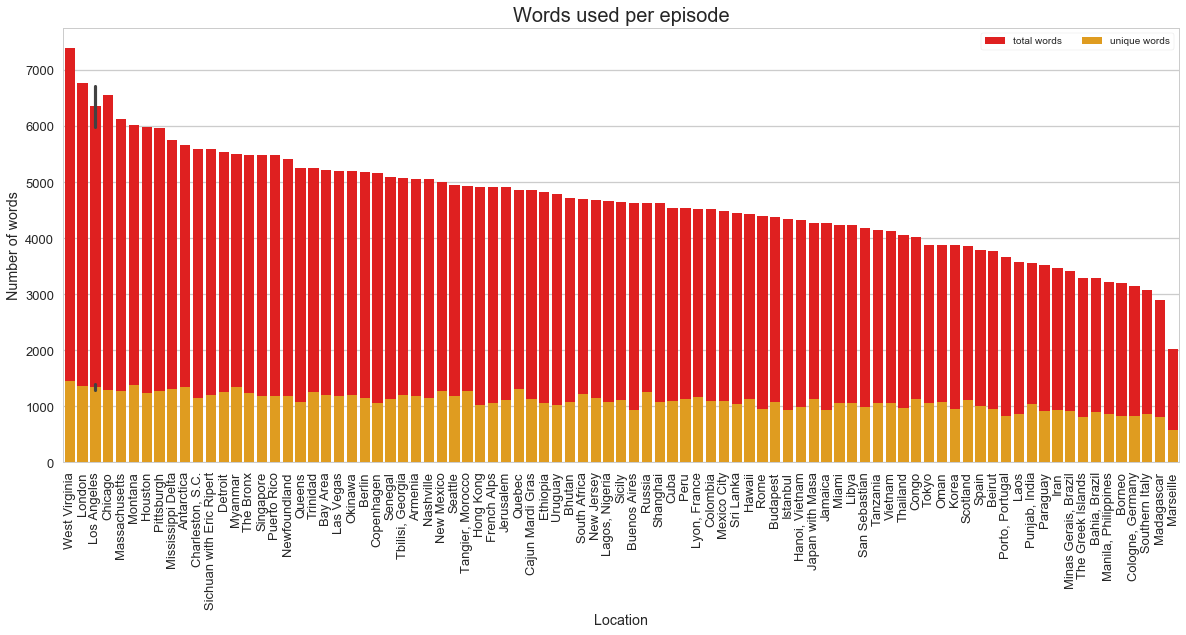

In [565]:
import seaborn as sns

sns.set_context(context='talk', font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(20,8))
sns.set(style="whitegrid")
                      
#plot total words per episode
sns.barplot(x="episode_location", y="vocab_count", 
            data=episode_vocab_count.sort_values('vocab_count', axis=0, ascending=False),
            color="red",
            label='total words')

#plot unique words per episode
sns.barplot(x="episode_location", y="unique_vocab_count", 
            data=episode_vocab_count.sort_values('vocab_count', axis=0, ascending=False),
            color="orange",
            label='unique words')

plt.setp(ax.get_xticklabels(), rotation=90)
ax.legend(ncol=2, loc="upper right", frameon=True)
plt.title('Words used per episode', fontsize=20)
plt.ylabel('Number of words')
plt.xlabel('Location')

plt.show()

## Identifying and Removing Stopwords

The `nltk stopwords` list of stop words isn't very comprehensive, so I wanted to generate a more detailed list of commonly used words. I made a function to return a data frame containing the tokens that occur above a certain threshold across the entire corpus. As an approximation, I defined 'common words' as tokens that occur in the corpus more than 960 times (average of 10 times per episode X 96 episodes). I added these words to the default `nltk stopwords` to create a corpus specific stopword list (`puk_stopwords`). I also removed words that were 2 or less characters in length. 

In [255]:
# returns words from provided vocab_count_list that occur above a certain threshold (num_occurances)
# returns df so occurances can be inspected

def id_common_words(vocab_count_list, num_occurances):
    word_counts = []
    for word in global_vocab:
        word_counts.append((word, len(vocab_count_list[word])))
    word_counts_df = pd.DataFrame.from_records(word_counts)
    word_counts_df.columns = ['word', 'number occurances']
    words_with_num_occurances = word_counts_df[word_counts_df['number occurances'] >= num_occurances]
    return(words_with_num_occurances)

In [338]:
common_words = list((id_common_words(global_vocab, 960)).word)
print("There are {} words that occur an average of 10 or more times per episode.".format(len(common_words)))

There are 74 words that occur an average of 10 or more times per episode.


In [339]:
# returns words from provided vocab_count_list that occur above a certain threshold (num_occurances)
# returns df so occurances can be inspected

def id_short_words(vocab_count_list, word_len):
    short_words = []
    for word in global_vocab:
        if len(word) <= word_len:
            short_words.append(word)
    return(short_words)

In [340]:
short_words = id_short_words(global_vocab, 2)
print("There are {} words that are 2 or fewer characters long.".format(len(short_words)))

There are 275 words that are 2 or fewer characters long.


In [341]:
from nltk.corpus import stopwords

# corpus specific stopwords

puk_stopwords = list(stopwords.words('english')) + common_words + short_words

In [342]:
# create list of words with and without stop words

all_vocab = list(global_vocab.keys())
vocab_std_stopwords = [w for w in all_vocab if w not in list(stopwords.words('english'))]
vocab_puk_stopwords = [w for w in all_vocab if w not in puk_stopwords]

print("The Parts Unknown 'corpus' contains {} words".format(len(all_vocab))) 
print("The Parts Unknown 'corpus' contains {} words not contained in standard stopwords".format(len(vocab_std_stopwords)))
print("The Parts Unknown 'corpus' contains {} words not contained in the corpus specific stopwords".format(len(vocab_puk_stopwords)))

The Parts Unknown 'corpus' contains 14060 words
The Parts Unknown 'corpus' contains 13936 words not contained in standard stopwords
The Parts Unknown 'corpus' contains 13678 words not contained in the corpus specific stopwords


## Now I'm using the functions defined in the reference below

In [318]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

Now that I have a better understanding of the words used in the Parts Unknown corpus, I wanted to see if I could identify common themes across the episodes. I used NMF (Non-negative Matrix factorization) to model the topics in the episodes of Parts Unknown.

In [570]:
# get words from vectorizer and map back to NMF model; 
# modified from https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df

def get_nmf_topics(model, vectorizer, num_topics, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    n_top_words = -1 * n_top_words
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict)

#### Method 1. Use TfidfVectorizer with Porter Stemmer

In [738]:
# define stemmer and tokenizer and fit TfidfVectorizer

token_dict = {}
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text.translate(translator))
    stems = stem_tokens(tokens, stemmer)
    return stems

for idx, episode in puk.iterrows():
    episode_name = episode.episodeID
    text = episode.clean_text
    lowers = text.lower()
    no_punctuation = lowers.translate(string.punctuation)
    token_dict[episode_name] = no_punctuation
        
#this can take some time
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=puk_stopwords)
tfs = tfidf.fit_transform(token_dict.values())

In [739]:
# fit NMF model to tfs
model1 = NMF(n_components=20, init='nndsvd', random_state=42)

W1 = model1.fit_transform( tfs )

In [740]:
# get topic components

get_nmf_topics(model1, tfidf, 20, 15)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,gon,sushi,brazil,korean,newfoundland,mexico,itali,armenian,vietnam,singapor,miami,hawaiian,congo,cologn,hong,iranian,paraguay,beirut,basqu,bronx
1,got,tokyo,salvador,korea,chef,mexican,rome,russia,lao,china,detroit,okinawa,india,berlin,kong,iran,gaddafi,gaza,san,hop
2,mean,manga,caipirinha,han,chocol,taco,sicili,georgia,vietnames,chines,beach,okinawan,bhutan,german,filipino,tehran,libya,palestinian,francisco,hip
3,work,yasuda,brazilian,food,fish,cartel,sicilian,putin,hanoi,shanghai,jersey,island,madagascar,turkish,christma,kabob,libyan,sri,sebastián,borough
4,want,japanes,african,seoul,lyon,trejo,roman,russian,hue,singaporean,cuba,hawaii,lion,germani,philippin,sanction,lopez,syria,panther,crackhead
5,pittsburgh,stanc,bahia,game,marseil,drug,mussolini,armenia,war,éric,live,greek,masai,carniv,merri,guest,madam,trinidad,grill,music
6,lot,japan,capoeira,drink,food,spanish,see,georgian,rice,sichuan,place,yama,glasgow,kolsch,halo,saffron,tripoli,isra,sea,jamaican
7,nashvil,tentacl,detroit,rockaway,eat,gun,tapa,soviet,noodl,wed,vega,japanes,yak,refuge,adobo,axi,lynch,oman,food,place
8,puerto,karat,cachaca,roy,cook,mescal,portug,turkey,back,food,colombia,naxo,day,beer,lechón,jason,misrata,hezbollah,place,lammi
9,mine,sex,pellorinio,queen,eric,topito,beauti,istanbul,countri,noodl,tangier,greec,would,citi,jolli,kingdom,countri,israel,jiu,record


In [767]:
# save topics to df with labels

topic1_names = ['random', 'japanese_weirdness', 'brazil_african', 'korea', 'generic_euro_french','sw_tacos',
               'southern_euro', 'ussr&pals', 'se_asia', 'hawker_food', 'random2', 'islands', 'ex_colonies',
               'immigrants_germany', 'random_asian', 'iran', 'random3', 'troubled_regions', 'random4', 'NYC']

topics1 = get_nmf_topics(model1, tfidf, 20, 15)
topics1.columns = topic_names

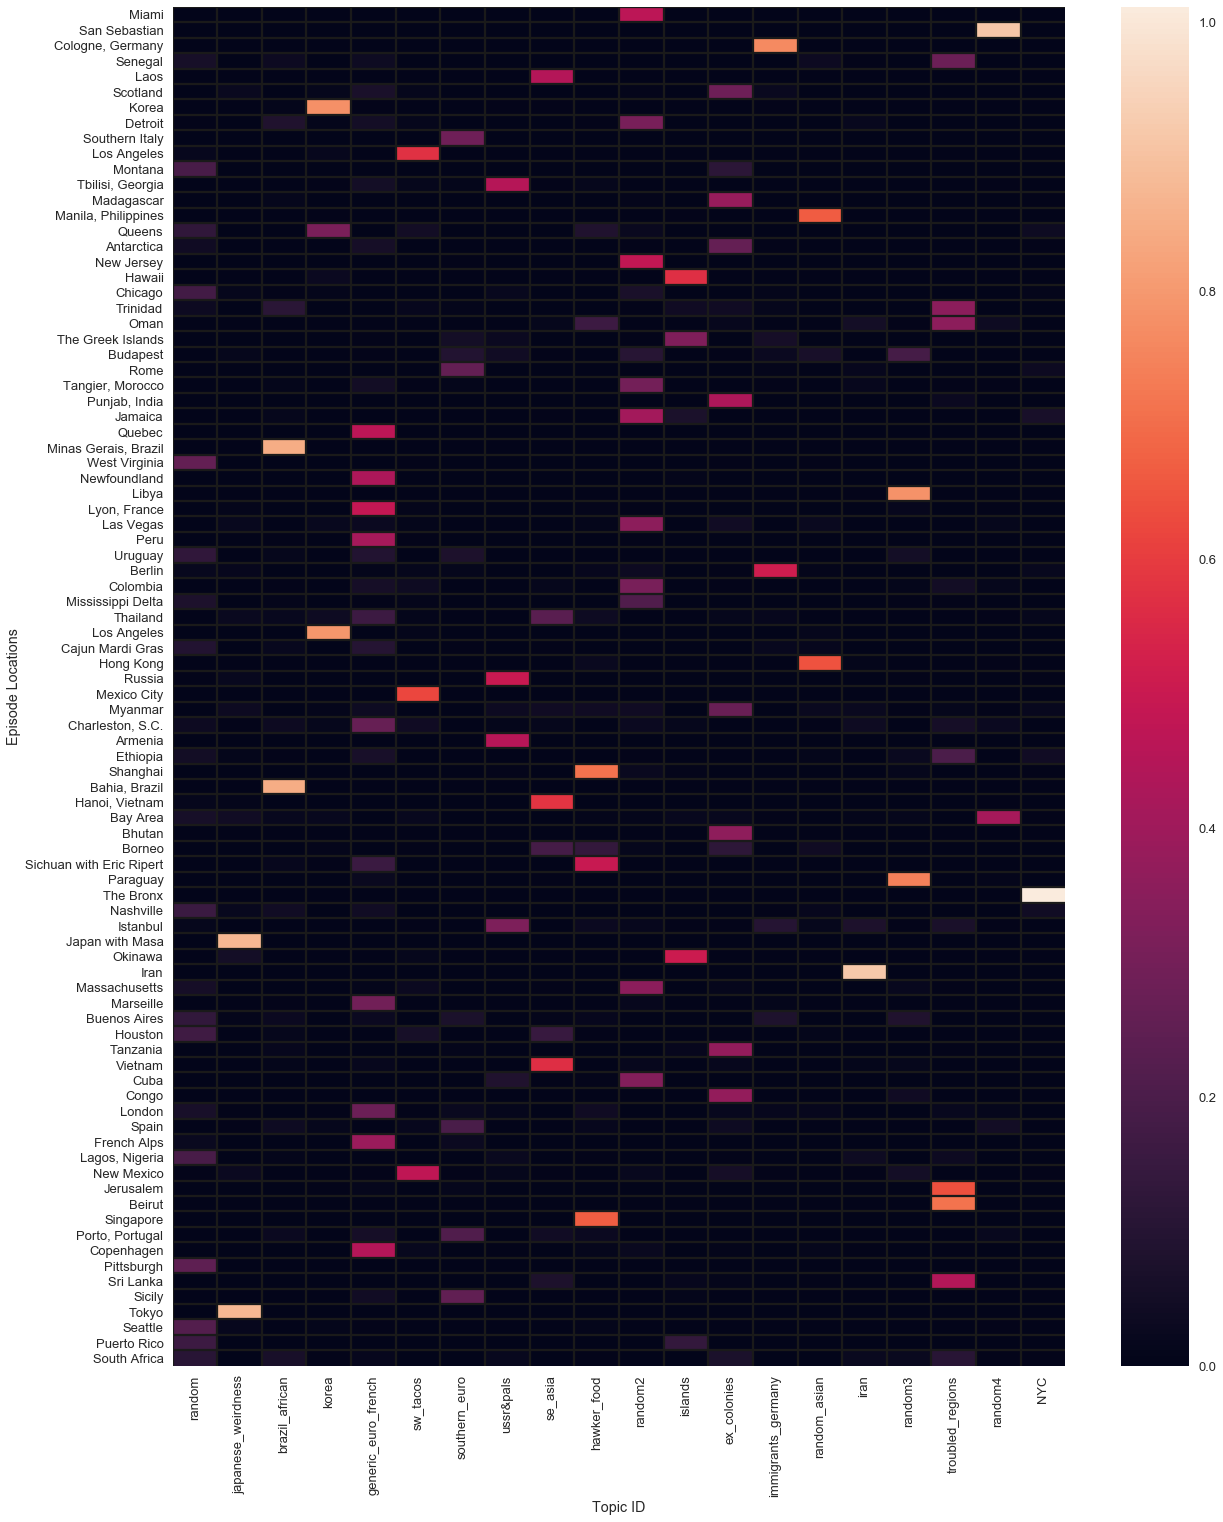

In [768]:
# set up df of episode scores by topics

episode_locations = puk.episode_location
episode1_scores = pd.DataFrame(W1,index=episode_locations)
episode1_scores.columns = topic1_names

import matplotlib.pyplot as plt

sns.set_context(context='talk', font_scale=1)
# Draw a heatmap with the numeric values in each cell
plt.subplots(figsize=(20,25))
ax = sns.heatmap(episode1_scores)
ax.hlines([range(len(episode1_scores))], *ax.get_xlim())
ax.vlines([range(20)], *ax.get_ylim())
ax.set_xlabel('Topic ID')
ax.set_ylabel('Episode Locations')
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

#### Method 2. Use TfidfVectorizer without stemming

In [729]:
# define data for the vectorizer and transformer functions
data = list(puk.clean_text)

In [730]:
# use tfidf vectorizer to vectorize and transform the data

tfidf_vectorizer = TfidfVectorizer(stop_words=set(puk_stopwords),
                                   smooth_idf=False,
                                   max_features=10000,
                                   max_df=60)

tfidf = tfidf_vectorizer.fit_transform(data)

In [731]:
# fit NMF model
model = NMF(n_components=20, init='nndsvd', random_state=42)

W = model.fit_transform( tfidf )
H = model.components_

In [732]:
# get top 20 topics 

get_nmf_topics(model, tfidf_vectorizer, 20, 15)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,uruguay,tokyo,brazil,korean,vietnam,mexico,russia,gonna,sicily,miami,china,newfoundland,beirut,hong,berlin,mississippi,tangier,india,vegas,senegal
1,marseille,sushi,salvador,koreans,vietnamese,mexican,georgia,puerto,italy,bronx,singapore,basque,gaza,kong,cologne,chicago,burroughs,glasgow,congo,africa
2,paraguay,manga,caipirinha,korea,hanoi,trejo,putin,pittsburgh,rome,jamaica,éric,quebec,sri,christmas,turkish,detroit,morocco,bhutan,antarctica,senegalese
3,chocolate,yasuda,brazilian,han,lao,spanish,armenian,coal,sicilian,hawaiian,chinese,french,palestinian,merry,german,nashville,moroccan,madagascar,ice,soweto
4,eric,japanese,bahia,queens,hue,topito,armenia,braddock,mussolini,cuba,shanghai,moose,gaddafi,filipino,germany,delta,bowles,punjab,mcmurdo,south
5,aires,stance,african,seoul,war,gun,russian,rico,portugal,beach,sichuan,fred,syria,philippines,carnival,ale,socco,myanmar,congolese,johannesburg
6,buenos,japan,pellorinio,koreatown,laos,tacos,soviet,britt,mmm,island,noodles,maple,libya,filipinos,kolsch,roger,heroin,pakistan,scientists,dakar
7,cheese,tentacle,capoeira,sizzler,squid,morrissey,georgian,virginia,spain,colombia,thailand,mardi,iran,halo,weimar,cubs,jajouka,yak,sinatra,african
8,chef,karate,cachaca,roy,houston,santa,istanbul,seattle,wine,blackwell,sichuanese,gras,hezbollah,manila,istanbul,sox,moroccans,indian,water,ethiopia
9,france,sex,instruments,kimchi,rice,nate,turkey,montana,tarantula,okinawa,longhouse,cod,israel,jolly,refugees,cub,pats,yangon,station,mandela


In [771]:
# save topics to df with labels

topic_names = ['random', 'japanese_weirdness', 'brazil_african', 'korea', 'se_asian_treats', 
 'cartel_tacos', 'ussr&pals', 'random2', 'southern_euro', 'island_influence', 
 'chinese_sphere', 'loosely_french(ish)', 'troubled_placed', 'random_3', 'immigrants_germany', 
 'usa', 'interzone', 'ex_colonies', 'no_idea', 'africa'] 

topics = get_nmf_topics(model, tfidf_vectorizer, 20, 15)
topics.columns = topic_names

In [772]:
# set up df of episode scores by topics

episode_locations = puk.episode_location
episode_scores = pd.DataFrame(W,index=episode_locations)
episode_scores.columns = topic_names

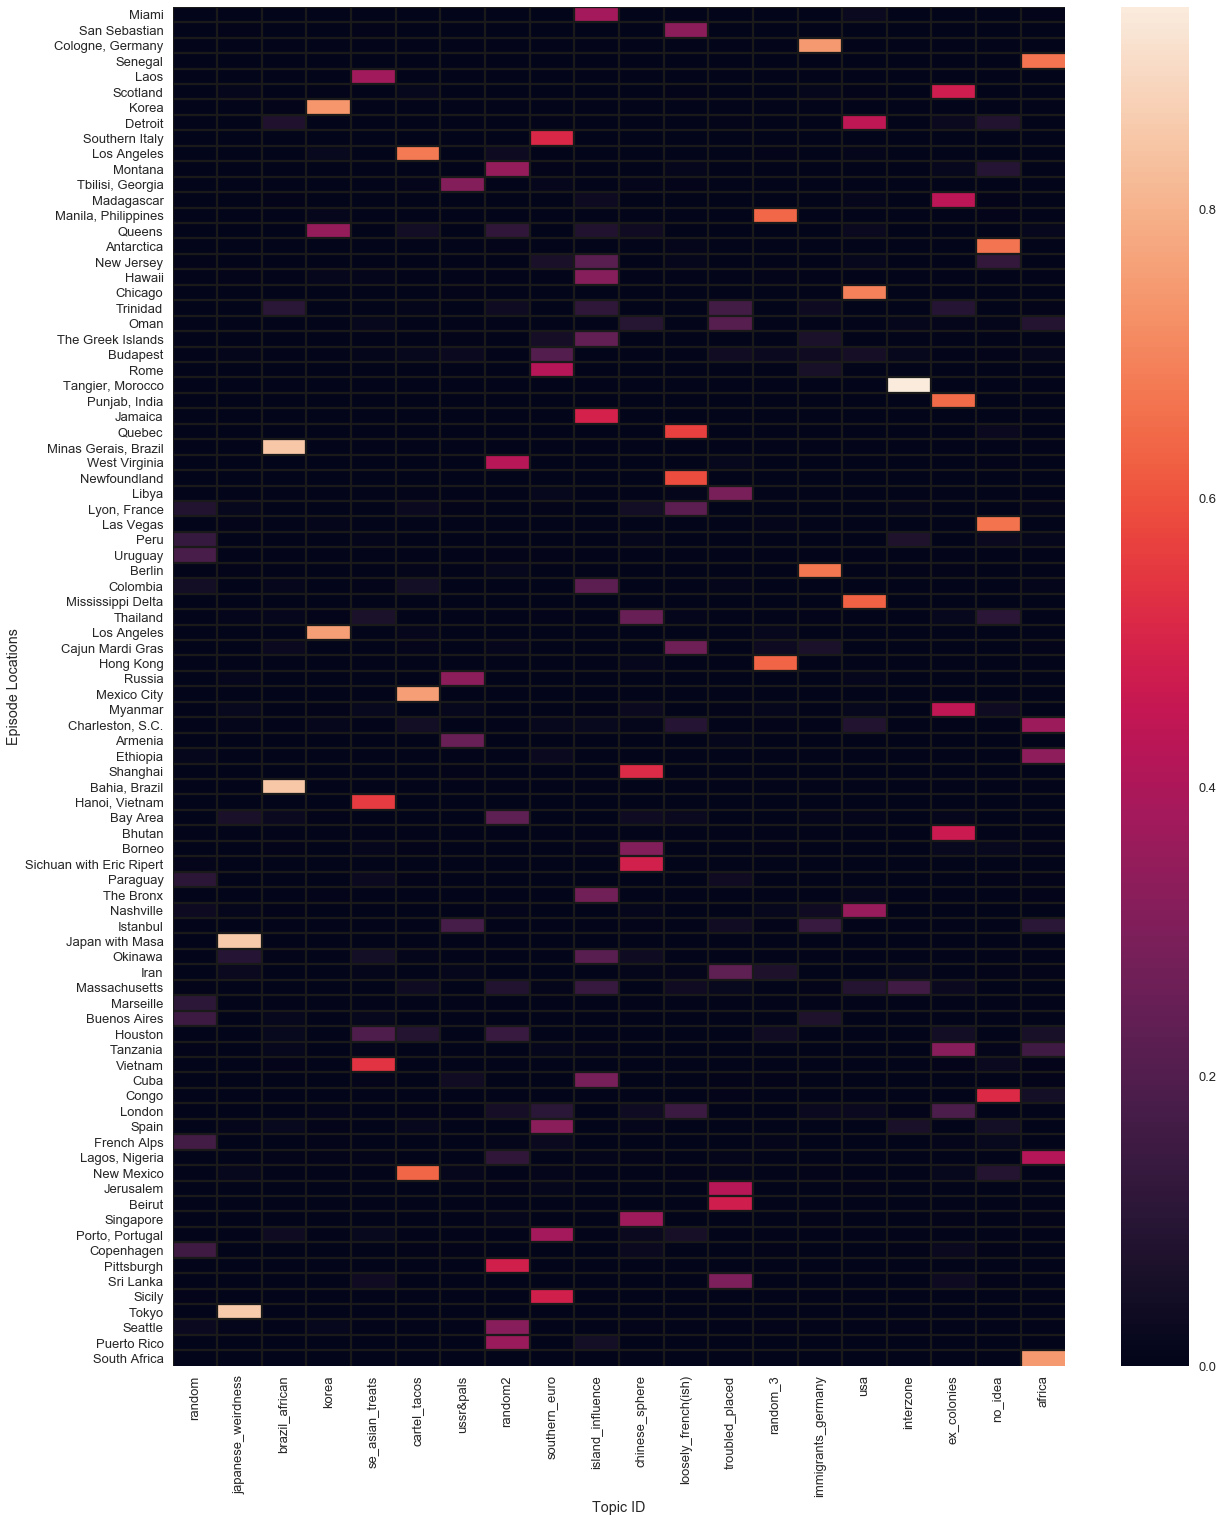

In [773]:
import matplotlib.pyplot as plt

sns.set_context(context='talk', font_scale=1)
# Draw a heatmap with the numeric values in each cell
plt.subplots(figsize=(20,25))
ax = sns.heatmap(episode_scores)
ax.hlines([range(len(episode_scores))], *ax.get_xlim())
ax.vlines([range(20)], *ax.get_ylim())
ax.set_xlabel('Topic ID')
ax.set_ylabel('Episode Locations')
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

In [775]:
print('The sum of topic scores for the non-stemmed NMF model:')
episode_scores.sum().sort_values(ascending=False)

The sum of topic scores for the non-stemmed NMF model:


ex_colonies            3.359689
island_influence       3.126909
africa                 3.105608
random2                2.850160
southern_euro          2.733614
no_idea                2.600350
usa                    2.542259
cartel_tacos           2.509570
loosely_french(ish)    2.420339
chinese_sphere         2.412678
troubled_placed        2.335265
brazil_african         2.124269
japanese_weirdness     2.071258
se_asian_treats        2.021640
immigrants_germany     2.018444
korea                  1.989581
random_3               1.564959
interzone              1.336614
random                 1.243282
ussr&pals              1.234283
dtype: float64

In [776]:
print('The sum of topic scores for the stemmed NMF model:')
episode1_scores.sum().sort_values(ascending=False)

The sum of topic scores for the stemmed NMF model:


generic_euro_french    4.820197
random2                4.048323
troubled_regions       3.410335
ex_colonies            3.393633
random                 2.951176
hawker_food            2.622650
se_asia                2.440920
brazil_african         2.401712
japanese_weirdness     2.166343
korea                  2.143870
sw_tacos               2.141069
random3                2.122829
ussr&pals              2.063828
islands                1.798415
immigrants_germany     1.723762
southern_euro          1.668538
random_asian           1.652198
random4                1.581621
NYC                    1.359760
iran                   1.297719
dtype: float64

### Method 3. No Stemming and allowance of n-grams (n=1-3)

In [1149]:
# define data for the vectorizer and transformer functions
data = list(puk.clean_text)

# use tfidf vectorizer to vectorize and transform the data

tfidf_vectorizer = TfidfVectorizer(stop_words=set(puk_stopwords),
                                   smooth_idf=False,
                                   max_features=10000,
                                   max_df=60,
                                  ngram_range=(1,3))

tfidf = tfidf_vectorizer.fit_transform(data)

# fit NMF model
model = NMF(n_components=15, init='nndsvd', random_state=42)

W = model.fit_transform( tfidf )
H = model.components_

# get top 20 topics 

get_nmf_topics(model, tfidf_vectorizer, 15, 15)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15
0,newfoundland,tokyo,brazil,korean,vietnam,mexico,russia,gonna,berlin,sicily,senegal,miami,china,vegas,beirut
1,lyon,sushi,salvador,koreans,vietnamese,mexican,georgia,pittsburgh,cologne,basque,africa,bronx,singapore,thailand,gaza
2,marseille,manga,caipirinha,korea,hanoi,new mexico,putin,puerto,nashville,tangier,mississippi,cuba,hong,madagascar,oman
3,quebec,yasuda,brazilian,han,lao,trejo,armenian,coal,uruguay,italy,south africa,jamaica,hong kong,andy,india
4,chef,japanese,bahia,seoul,hue,topito,armenia,braddock,buenos aires,spain,senegalese,hawaiian,kong,thai,sri
5,france,stance,detroit,queens,war,spanish,russian,west virginia,aires,sicilian,south,beach,shanghai,longhouse,trinidad
6,cheese,japan,world cup,koreatown,laos,tacos,istanbul,montana,buenos,tapas,charleston,colombia,chinese,chiang mai,palestinian
7,french,tentacle,african,sizzler,houston,gun,turkey,butte,rome,portugal,congo,jersey,éric,chiang,gaddafi
8,chocolate,karate,pellorinio,roy,squid,morrissey,soviet,virginia,mardi,wine,african,island,sichuan,gawai,syria
9,eric,sex,capoeira,kimchi,long bay,santa,georgian,rico,music,granada,soweto,atlantic city,christmas,iban,war


## Some tests with cosine similarity

In [970]:
# define data for the vectorizer and transformer functions
data = list(puk.clean_text)
episode_names = list(puk.episode_location)

# I need to address the fact that there are two LA episodes
episode_names[9] = 'Los Angeles_1'
episode_names[40] = 'Los Angeles_2'

In [1153]:
# use tfidf vectorizer to vectorize and transform the data

tfidf_vectorizer = TfidfVectorizer(stop_words=set(puk_stopwords),
                                   smooth_idf=True,
                                   max_features=10000,
                                   max_df=60)

tfidf = tfidf_vectorizer.fit_transform(data)

In [1154]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf)

In [1155]:
# make df with similarity scores mapped to episodes 

cosine_sim = pd.DataFrame(dist, episode_names)
cosine_sim.columns = episode_names

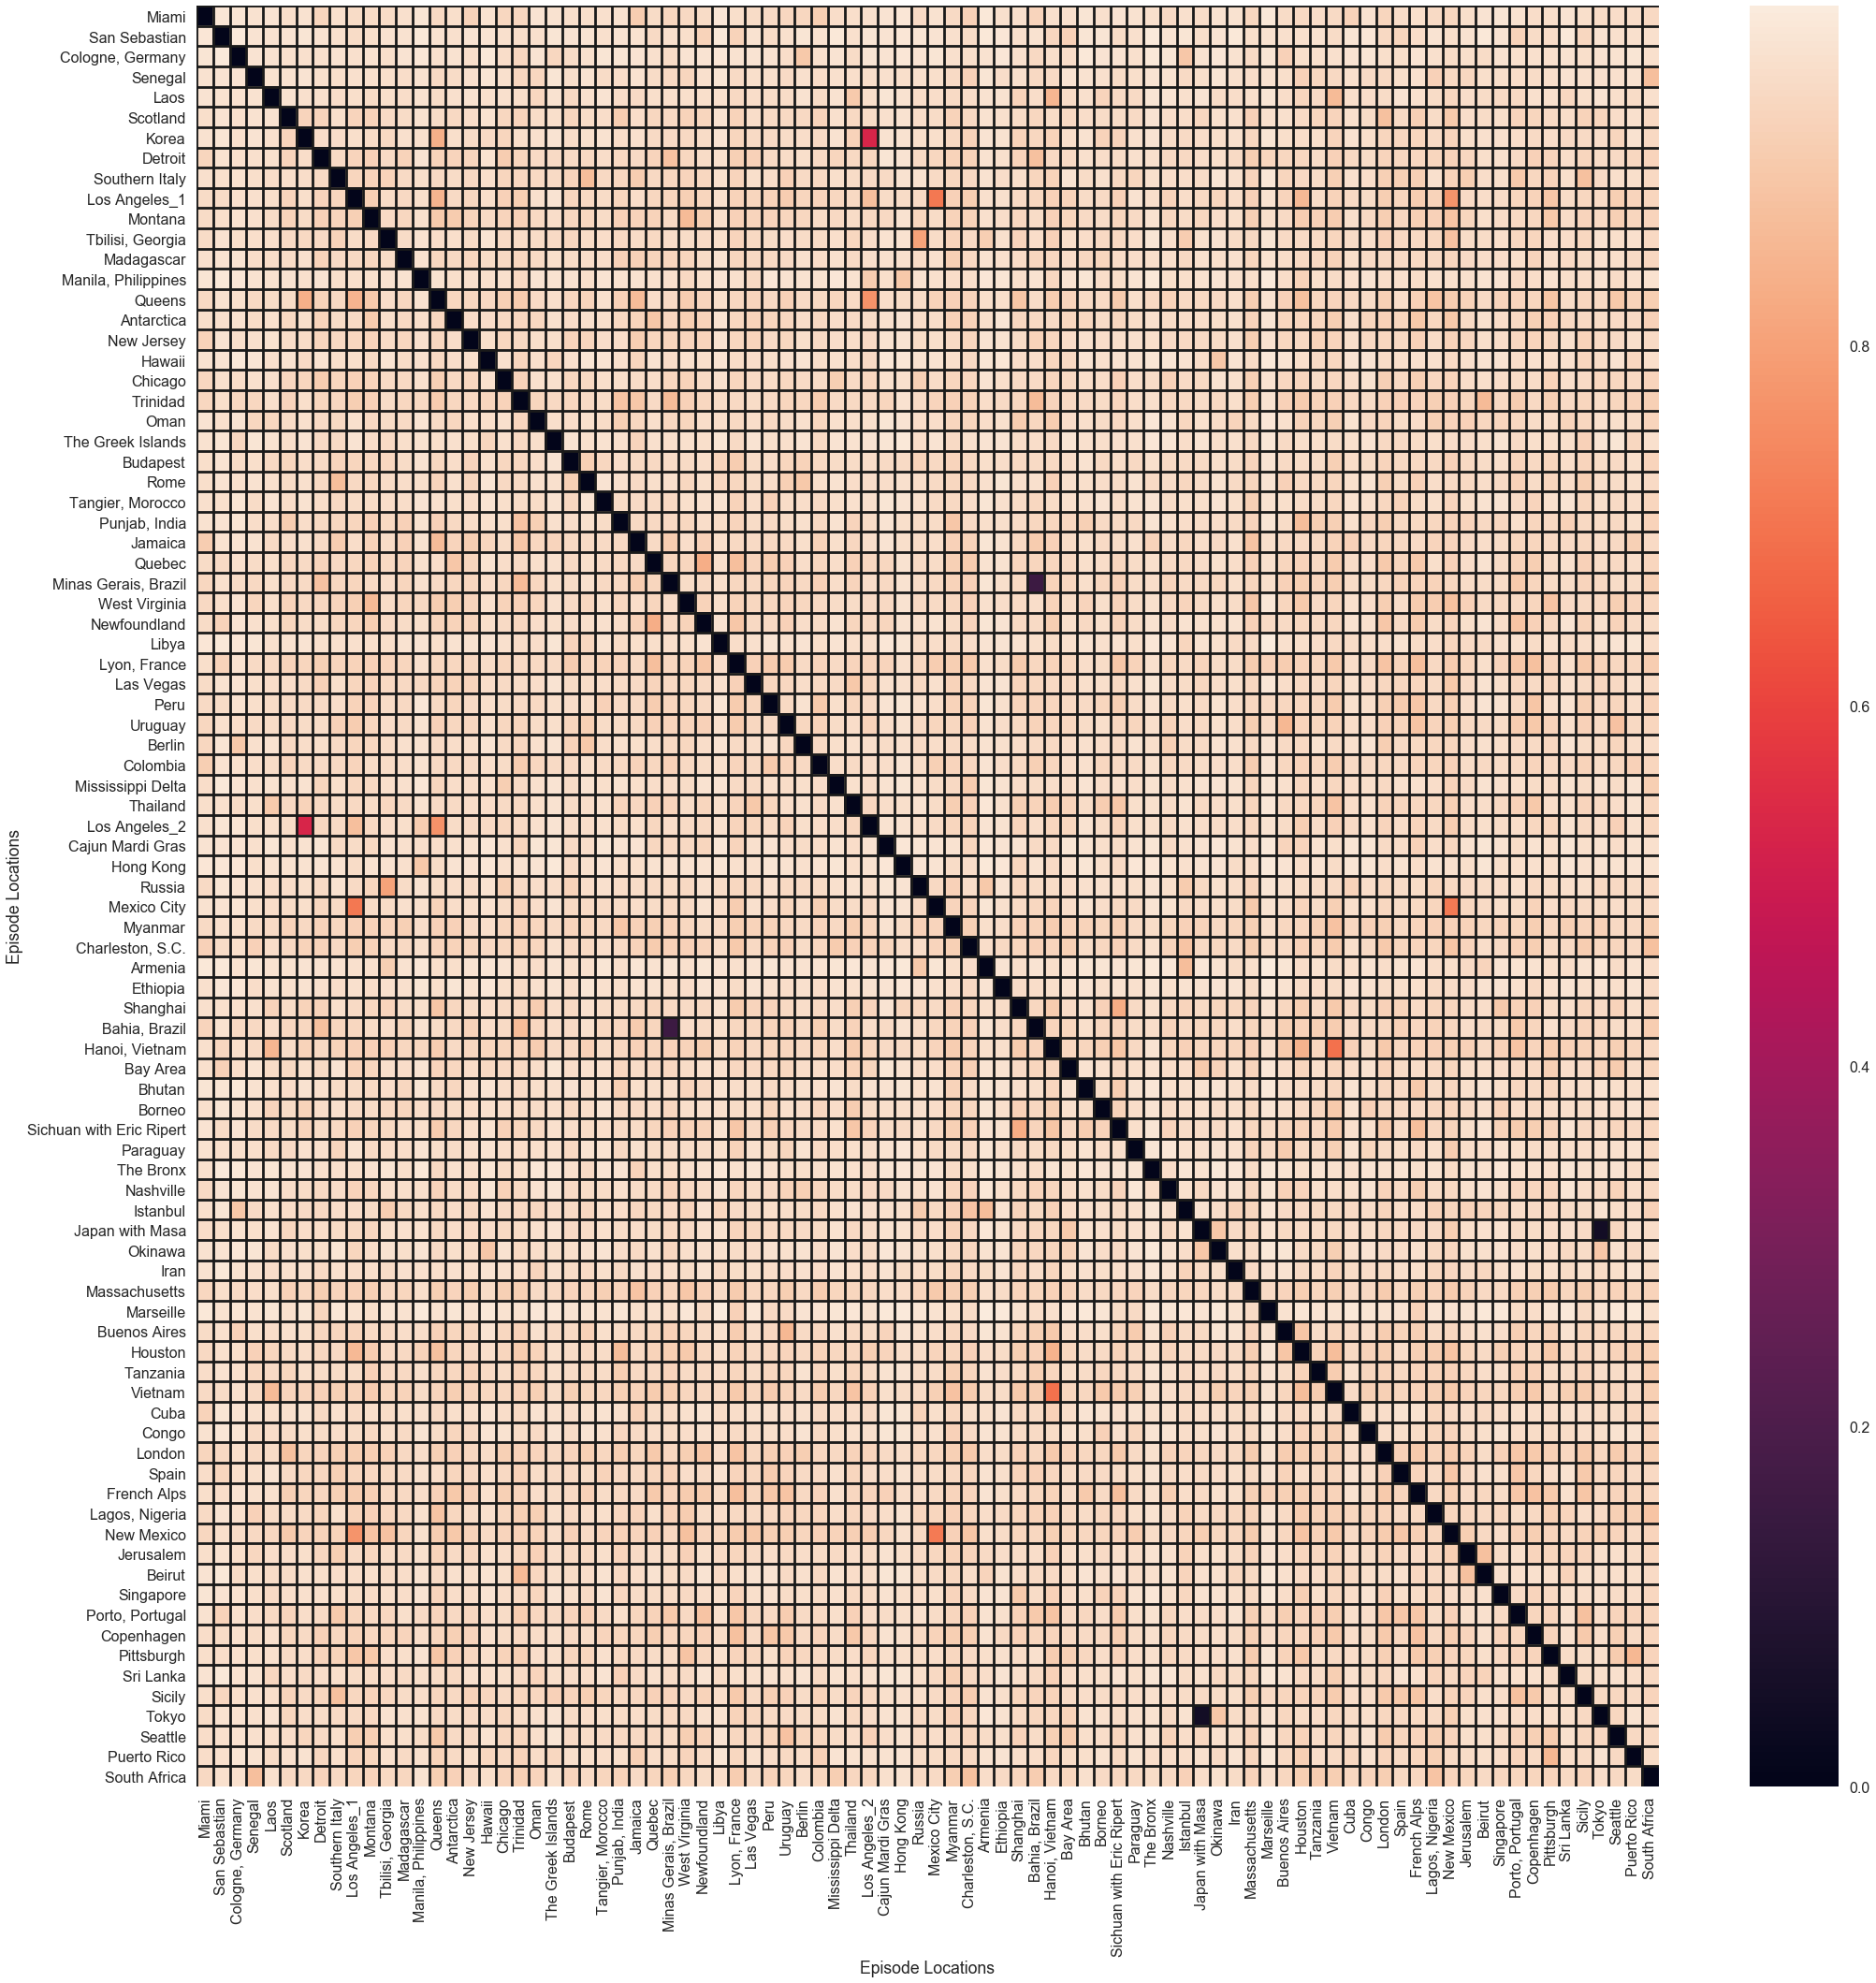

In [1086]:
# Draw a heatmap with the numeric values in each cell

sns.set_context(context='poster', font_scale=1)

plt.subplots(figsize=(35,35))
ax = sns.heatmap(cosine_sim)
ax.hlines([range(len(cosine_sim))], *ax.get_xlim())
ax.vlines([range(len(cosine_sim))], *ax.get_ylim())
ax.set_xlabel('Episode Locations')
ax.set_ylabel('Episode Locations')
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

In [1156]:
# identifying the number of similar locations based on arbitrary threshold (here 0.9)

similar_places = cosine_sim[cosine_sim < 0.90].count(axis=0, level=None, numeric_only=False)
similar_places = pd.DataFrame(similar_places)
similar_places.reset_index(inplace=True)
similar_places.columns = ['location', 'num_similar']

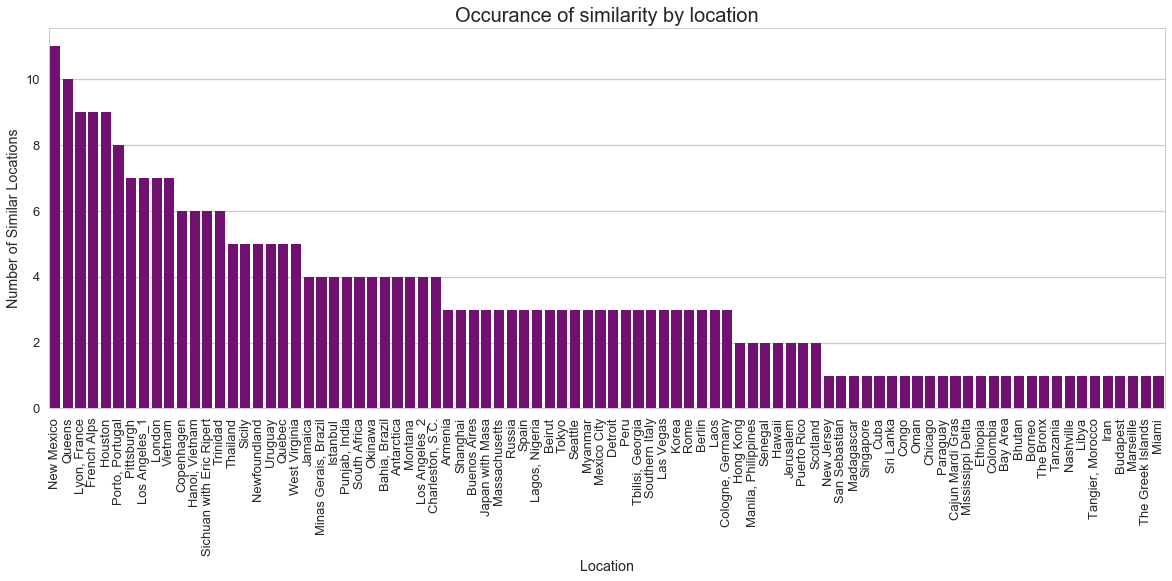

In [1088]:
sns.set_context(context='talk', font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(20,7))
sns.set(style="whitegrid")
                      
#plot total words per episode
sns.barplot(x="location", y="num_similar", 
            data=similar_places.sort_values('num_similar', axis=0, ascending=False),
            color="purple")

plt.setp(ax.get_xticklabels(), rotation=90)
plt.title('Occurance of similarity by location', fontsize=20)
plt.ylabel('Number of Similar Locations')
plt.xlabel('Location')

plt.show()

In [1157]:
# create a list of the 3 most similar locations for each location
list_similar = []

for column in cosine_sim:
    most_similar = cosine_sim.nsmallest(4, column).index
    similar = (most_similar[0], most_similar[1], most_similar[2], most_similar[3])
    list_similar.append(similar)

In [1158]:
list_similar_df = pd.DataFrame.from_records(list_similar, columns=['location', 
                                                                   'similar_1',
                                                                   'similar_2', 
                                                                   'similar_3'])

In [1161]:
print('Examples of Most similar locations based on cosine similarity of episode text:')
print(list_similar_df[list_similar_df.location == 'Korea'].values)
print(list_similar_df[list_similar_df.location == 'Detroit'].values)
print(list_similar_df[list_similar_df.location == 'Los Angeles_1'].values)
print(list_similar_df[list_similar_df.location == 'Russia'].values)
print(list_similar_df[list_similar_df.location == 'Okinawa'].values)
print(list_similar_df[list_similar_df.location == 'Southern Italy'].values)
print(list_similar_df[list_similar_df.location == 'Laos'].values)
print(list_similar_df[list_similar_df.location == 'Miami'].values)
print(list_similar_df[list_similar_df.location == 'Cuba'].values)
print(list_similar_df[list_similar_df.location == 'Hong Kong'].values)

Examples of Most similar locations based on cosine similarity of episode text:
[['Korea' 'Los Angeles_2' 'Queens' 'Thailand']]
[['Detroit' 'Bahia, Brazil' 'Minas Gerais, Brazil' 'Chicago']]
[['Los Angeles_1' 'Mexico City' 'New Mexico' 'Queens']]
[['Russia' 'Tbilisi, Georgia' 'Armenia' 'Istanbul']]
[['Okinawa' 'Hawaii' 'Japan with Masa' 'Tokyo']]
[['Southern Italy' 'Rome' 'Sicily' 'Porto, Portugal']]
[['Laos' 'Hanoi, Vietnam' 'Vietnam' 'Thailand']]
[['Miami' 'Jamaica' 'Colombia' 'Charleston, S.C.']]
[['Cuba' 'Hanoi, Vietnam' 'Jamaica' 'Miami']]
[['Hong Kong' 'Manila, Philippines' 'Shanghai' 'Hanoi, Vietnam']]


In addition to topic modeling, I used cosine similarity to identify similarities in the episodes. Based on these similarities I identified the 3 most similar locations for each location. While some of these associations didn't make sense, a surprising number of reasonable relationships were identified. Cosine similarity identified both geographic and cultural/political similarities between episode locations.

For example, 'Southern Italy' was found to be related to Sicily (a region of Southern Italy), Rome (an Italian city), and Porto, Portugal (a southern European city). Regionally, these relationships make sense. 

Similarly, Russia was found to be most similar to Georgia, Armenia, and Istanbul. Russia/Georgia/Armenia are all part of the former USSR, and Istanbul, Turkey is both geographically proximal and has an interconnect (to put it diplomatically) history with Armenia (which it borders) and Russia.

The Cuba episode was most similar to episodes located in Jamaica, Miami, and Hanoi, Vietnam. Cuba is geographically and culturally related to Jamaica and Miami, but the relationship with Hanoi, Vietnam is not geographic but political. Both Cuba and Vietnam are socialist countries that have had conflicts with the United States, and Hanoi is the still the seat of the socialist party in Vietnam.

## I noticed that lots of the topics were related to proper nouns like place names and ethnicities. I wanted to see if I could identify more broad topics by removing these words.

## Try using countries and nationalities as stopwords

In [1476]:
# read in csv with episode location information
place_names = pd.DataFrame.from_csv('supplemental_data/world-cities.csv',  index_col=None)

In [1568]:
# list of countries

countries = list(place_names.country.unique())
countries = [i.lower() for i in countries]

In [1569]:
# list of cities

cities = list(place_names.name.unique())
cities = [i.lower() for i in cities]

In [1570]:
# list of subcountry (this includes some cities)

subcountry = list(place_names.subcountry.unique())
subcountry = [i.lower() for i in subcountry if isinstance(i, six.string_types)]

In [1571]:
# list of nationalities
nationalities = pd.DataFrame.from_csv('supplemental_data/nationalities.csv',  index_col=None)

In [1572]:
nationalities_list = nationalities.columns
nationalities = [i.lower() for i in nationalities]
plural_nationalities = [i+'s' for i in nationalities]

In [1591]:
continents = ['asia', 'africa', 'north' 'america', 'south', 'antarctica', 'europe', 'australia']

In [1735]:
exceptions = ['bogota', 'korea', 'korean', 'koreans','istanbul', 'lao', 'hawaiian', 'naxos', 'okinawan', 'bronx',
             'romans', 'vegas', 'cologne', 'glasgow', 'congo', 'puerto', 'rico', 'sri', 'lanka', 'lankan', 'britt', 
             'gonna', 'okinawans', 'atlantic', 'palestinian', 'buenos', 'aires', 'éric', 'eric', 'andy', '000',
             'queens', 'francisco', 'sicilian', 'newfoundland', 'chiang mai', 'chiang', 'mai', 'zamir', 'ricans',
             'braddock', 'blackwell', 'serj', 'jiu', 'jitsu']

In [1736]:
puk_stopwords_countries = (puk_stopwords + countries + cities + subcountry + 
                           nationalities + plural_nationalities + continents + exceptions)

In [1665]:
# define stemmer and tokenizer and fit TfidfVectorizer

token_dict = {}
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text.translate(translator))
    stems = stem_tokens(tokens, stemmer)
    return stems

for idx, episode in puk.iterrows():
    episode_name = episode.episodeID
    text = episode.clean_text
    lowers = text.lower()
    no_punctuation = lowers.translate(string.punctuation)
    token_dict[episode_name] = no_punctuation

In [1666]:
#this can take some time
tfidf = TfidfVectorizer(stop_words=set(puk_stopwords_countries),
                        smooth_idf=False,
                        max_features=10000,
                        max_df=60,
                        ngram_range=(1,4))

tfs = tfidf.fit_transform(token_dict.values())

# fit NMF model to tfs
model_themes = NMF(n_components=10, init='nndsvd', random_state=42)

W_themes = model_themes.fit_transform( tfs )

# get topic components

get_nmf_topics(model_themes, tfidf, 10, 10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,war,sushi,caipirinha,chocolate,music,coal,island,noodles,hong,carnival
1,putin,yasuda,african,cheese,white,gun,beach,rice,hong kong,mardi
2,soviet,stance,world cup,chef,community,mining,islands,drink,kong,mardi gras
3,gaddafi,tentacle,capoeira,wine,neighborhood,stream,yamas,beer,christmas,kolsch
4,political,karate,pellorinio,basque,street,mines,bond,spicy,merry christmas,gras
5,government,sex,cachaca,bread,black,desert,caribbean,drinking,merry,beer
6,hezbollah,lurid,instruments,farm,hip hop,masai,rum,war,halo,tango
7,revolution,want kill,pelourinho,sea,hop,ice,vieques,pork,jolly,summer
8,religious,bored,blowfish,moose,hip,mcmurdo,port antonio,hue,adobo,hmm
9,optimistic,kill want,music,pig,tech,river,ding,karaoke,lechón,therapy


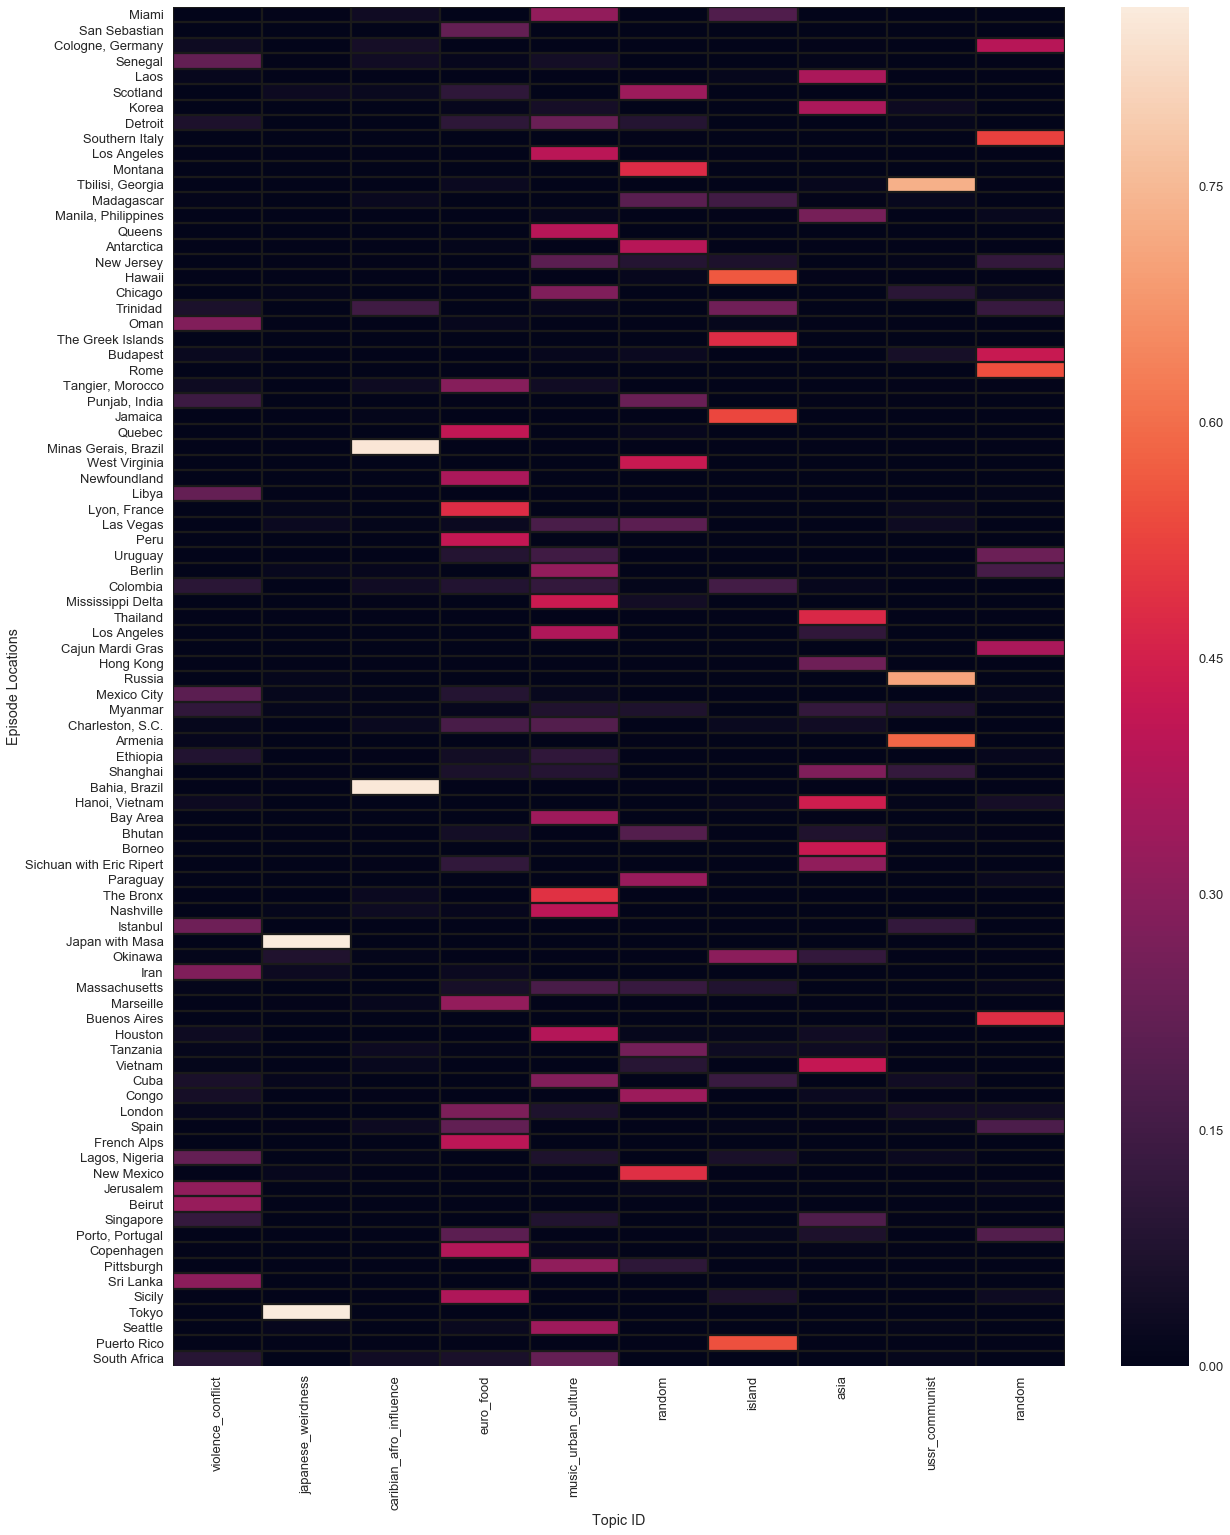

In [1619]:
# save topics to df with labels

topic_names = ['violence_conflict', 'japanese_weirdness', 'caribian_afro_influence', 'euro_food', 
               'music_urban_culture', 'random', 'island', 'asia', 'ussr_communist', 'random'] 

topics = get_nmf_topics(model_themes, tfidf, 10, 10)
topics.columns = topic_names

# set up df of episode scores by topics

episode_locations = puk.episode_location
episode_scores = pd.DataFrame(W_themes,index=episode_locations)
episode_scores.columns = topic_names

import matplotlib.pyplot as plt

sns.set_context(context='talk', font_scale=1)
# Draw a heatmap with the numeric values in each cell
plt.subplots(figsize=(20,25))
ax = sns.heatmap(episode_scores)
ax.hlines([range(len(episode_scores))], *ax.get_xlim())
ax.vlines([range(20)], *ax.get_ylim())
ax.set_xlabel('Topic ID')
ax.set_ylabel('Episode Locations')
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

## Clustering from http://brandonrose.org/clustering#Tf-idf-and-document-similarity

After identifying document similarity I used KMeans to identify clusters in the corpus. I ran an intial 'elbow' plot in an attempt to identify the appropriate number of clusters in the data, but I was unable to identify convergence in the data. No 'elbow' in the KMeans fit does not necessarily mean that there are no clusters in the data, but that the algorithm used cannot separate clusters. As an excersize I fit a KMeans model to 20 clusters (as for the topic modeling), and identified some of the similar connections in the data.

I interpret this lack of 'elbow' to mean that clustering may not be a good fit for this data. While connections certainly exist in the data, a network analysis highlighting relationships (rather than clusters) might be more appropriate.

In [1737]:
# make tfidf from tokenized and stemmed data

tfidf_vectorizer = TfidfVectorizer(stop_words=set(puk_stopwords_countries),
                        smooth_idf=True,
                        max_features=10000,
                        max_df=60,
                        ngram_range=(1,4))

tfidf = tfidf_vectorizer.fit_transform(token_dict.values())

In [1738]:
#identify words in tfidf
terms = tfidf_vectorizer.get_feature_names()

In [1739]:
from sklearn.cluster import KMeans

num_clusters = 20

km = KMeans(n_clusters=num_clusters, random_state=42)

km.fit(tfidf)

clusters = km.labels_.tolist()

In [1740]:
from sklearn.externals import joblib

# pickle model
joblib.dump(km,  'doc_cluster.pkl')

#load pickled model
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [1741]:
# dictionary and df of episode content

episodes = { 'episodeID': list(puk.episodeID), 'episode_location': list(puk.episode_location), 'date': list(puk.air_date), 'cluster': clusters}

frame = pd.DataFrame(episodes, index = [clusters] , columns = ['episodeID', 'episode_location', 'date', 'cluster'])

In [1742]:
print("Top words per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster {} words:  ".format(i), end='')
    word_list = []
    episode_list = []
    for ind in order_centroids[i, :8]: #replace 6 with n words per cluster
        word = terms[ind]
        word_list.append(word)
    print('  '.join(word_list))

    for episode in frame.loc[i]['episode_location']:
        episode_list.append(episode)
    print("Cluster {} episodes, {} episodes:  ".format(i, len(episode_list)))
    print(', '.join(episode_list))

    print('') #add whitespace
    print('') #add whitespace

Top words per cluster:

Cluster 0 words:  gaddafi  war  hezbollah  tamil  misrata  freedom  killed  civil war
Cluster 0 episodes, 4 episodes:  
Libya, Jerusalem, Beirut, Sri Lanka


Cluster 1 words:  island  islands  yamas  beach  bond  karate  mainland  vieques
Cluster 1 episodes, 5 episodes:  
Hawaii, The Greek Islands, Jamaica, Okinawa, Puerto Rico


Cluster 2 words:  mardi  mardi gras  carnival  gras  kolsch  beer  nacho  mallmann
Cluster 2 episodes, 4 episodes:  
Cologne, Germany, Uruguay, Cajun Mardi Gras, Buenos Aires


Cluster 3 words:  tapas  burroughs  olive oil  bowles  paul bowles  olive  bull  zack
Cluster 3 episodes, 2 episodes:  
Tangier, Morocco, Spain


Cluster 4 words:  heroin  pizza  fishing  stream  line  truck  kids  car
Cluster 4 episodes, 8 episodes:  
Detroit, Montana, New Jersey, Los Angeles, Iran, Massachusetts, Marseille, Lagos, Nigeria


Cluster 5 words:  african  caipirinha  slavery  oil  carnival  capoeira  music  instruments
Cluster 5 episodes, 3 episodes

### Plotting clusters

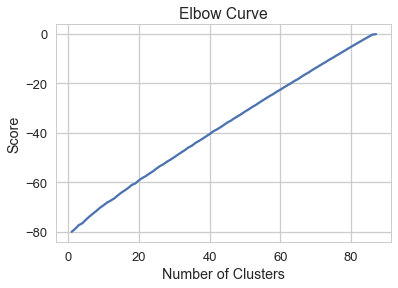

In [1667]:
num_clusters = range(1,88)

km = [KMeans(n_clusters=i) for i in num_clusters]

#km.fit(tfidf)

#clusters = km.labels_.tolist()

score = [km[i].fit(tfs).score(tfs) for i in range(len(km))]

plt.plot(num_clusters,score)

plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title('Elbow Curve')

plt.show()

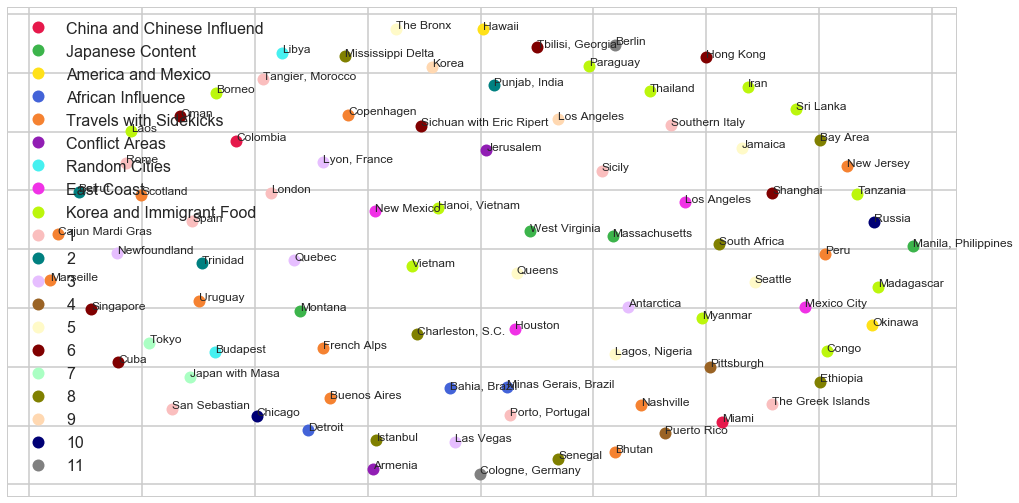

In [1353]:
# example from http://brandonrose.org/clustering#Tf-idf-and-document-similarity
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=list(puk.episode_location))) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=12)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

## Using TF-IDF to Identify common words

In [252]:
# create a dict of tf-idf for a sample review

test_tfidf = {}

# compute tf-idf and update dict
for token in r_vocab['S03E05']:
    if not token in test_tfidf:
        tf = np.log(1.*r_vocab['S03E05'].count(token)) + 1.
        idf = np.log(1. + len(puk)*1. / len(set(global_vocab[token])) )
        test_tfidf[token] = tf * idf
    
# sort the results decending by value
sorted_tfidf = sorted(test_tfidf.items(), key=lambda x: -x[1])

# print out results
for (k, v) in sorted_tfidf:
    print("%s : %f" % (k, v))

putin : 14.751331
russia : 11.327807
sochi : 10.916607
luna : 10.916607
mtv : 10.916607
blini : 9.600545
petersburg : 9.600545
moscow : 9.482519
gentl : 9.287029
russian : 8.988939
zamir : 8.167422
vladimir : 8.167422
alexand : 8.167422
trickl : 8.167422
propaganda : 8.167422
gay : 7.921019
olymp : 7.843142
birch : 7.745659
kgb : 7.745659
explet : 7.745659
yoy : 7.745659
polonium : 7.745659
levedev : 7.745659
bentley : 7.745659
lesbian : 7.745659
sergei : 7.745659
czar : 7.745659
uri : 7.745659
ukrain : 7.745659
billionair : 6.755172
accus : 6.755172
palac : 6.590937
maximum : 6.589425
oligarch : 6.589425
radioact : 6.589425
conspiraci : 6.589425
26 : 6.589425
cedar : 6.589425
hooligan : 6.589425
skinhead : 6.589425
soviet : 6.120724
dose : 5.920102
repercuss : 5.920102
critic : 5.896180
caviar : 5.862495
imperi : 5.642788
billion : 5.544513
ralli : 5.450031
journal : 5.450031
seri : 5.432513
activist : 5.428661
2001 : 5.089063
vodka : 5.089063
allegedli : 5.089063
salmon : 5.089063
co

alcohol : 1.410200
kitchen : 1.410200
win : 1.410200
small : 1.408247
her : 1.408247
ago : 1.395450
danc : 1.386294
master : 1.386294
warm : 1.386294
clear : 1.386294
woman : 1.386294
recip : 1.386294
same : 1.382897
end : 1.370579
univers : 1.363305
yep : 1.363305
exampl : 1.363305
brother : 1.363305
push : 1.363305
level : 1.363305
social : 1.363305
italian : 1.363305
couldn : 1.363305
surpris : 1.363305
poor : 1.363305
tell : 1.358491
last : 1.346624
support : 1.341174
bodi : 1.341174
extrem : 1.341174
french : 1.341174
dude : 1.341174
said : 1.334974
wow : 1.323534
join : 1.319849
forget : 1.319849
practic : 1.319849
foreign : 1.319849
low : 1.319849
oper : 1.319849
respons : 1.319849
cuisin : 1.319849
amount : 1.319849
river : 1.319849
pretti : 1.301260
big : 1.301260
strong : 1.299283
decad : 1.299283
typic : 1.299283
product : 1.299283
clean : 1.299283
farm : 1.299283
wife : 1.299283
normal : 1.299283
alway : 1.290415
best : 1.290415
tradit : 1.290415
home : 1.279758
girl : 1.27

In [253]:
# create a dataframe to be used in plotting
test_tfidf_DF = pd.DataFrame.from_dict(test_tfidf, orient='index')
test_tfidf_DF.columns = ['TF-IDF']
test_tfidf_DF = test_tfidf_DF.sort_values('TF-IDF', ascending=False)
test_tfidf_DF.head()

,TF-IDF
putin,14.751331
russia,11.327807
mtv,10.916607
luna,10.916607
sochi,10.916607


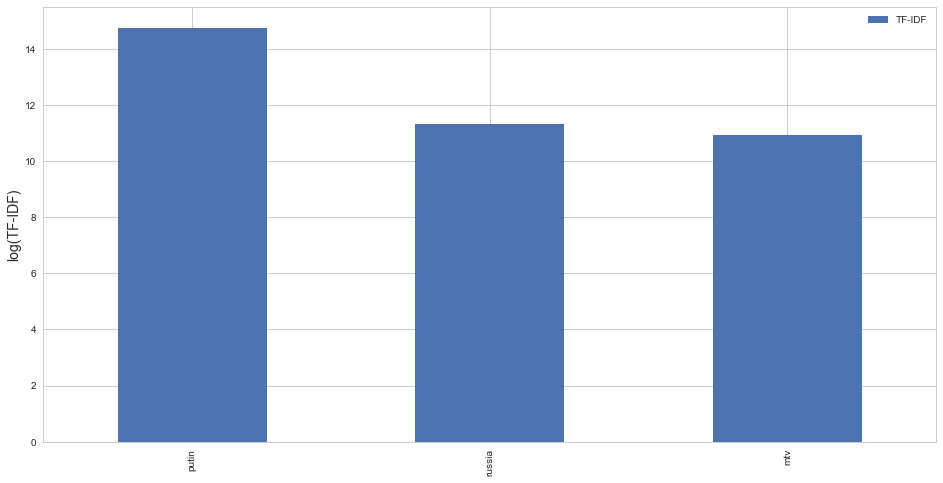

In [254]:
# plot the sample tf-idf results
fig, ax = plt.subplots(1, 1, figsize=(16,8))
test_testidf_DF = test_tfidf_DF.head(n=3)
test_testidf_DF.plot.bar(ax=ax)
plt.ylabel('log(TF-IDF)', size=14)

### Build a sparse feature matrix

In [93]:
# first define a stemmer and tokenizer that removes punctuation

porterStemmer = PorterStemmer()
# get list of lemmatized/stemmed tokens
def stemTokenList(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]
    
# get out stemmed tokens from text and remove punctuation

def noPunctWordTokenizerStemmer(text, stemmer=porterStemmer):
    # basic tokens to feed to our stem tokenizer
    tokens = nltk.word_tokenize(text.translate(translator))
    # stem
    stemmed_tokens = stemTokenList(tokens, stemmer)
    return stemmed_tokens

In [94]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert a collection of text documents to a matrix of token counts
# we get to pass our custom tokenizer
counter = CountVectorizer(stop_words='english', tokenizer=noPunctWordTokenizerStemmer)
# create the sparse matrix using counter on reviews
features_counts = counter.fit_transform(puk['clean_text'].values)

print("Count matrix of %d reviews with %d feature tokens" % features_counts.shape)

Count matrix of 96 reviews with 13857 feature tokens


Next we use TfidfTransformer to transform our sparse count matrix to a normalizedtf-idf representation:

In [261]:
from sklearn.feature_extraction.text import TfidfTransformer

In [260]:
# create the transformer
# use_id=True tells it to return tf-idf instead of just tf
tfidf = TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=True)
# get the transformation of our counts matrix
features_tfidf = tfidf.fit_transform(features_counts)

print("TF-IDF matrix of %d reviews with %d feature tokens" % features_tfidf.shape)

NameError: name 'features_counts' is not defined

In [96]:
counts_names = [counter.get_feature_names()[idx] for idx in features_counts[8,:].indices]
counts_values = features_counts[8,:].data

for i in range(len(counts_values)):
    print(counts_names[i], ':', counts_values[i])

shine : 1
poison : 1
immun : 1
inhabit : 1
site : 1
sacr : 1
prosciutto : 2
blind : 2
damascu : 1
heret : 1
persecut : 1
behead : 2
lop : 1
upsid : 1
crucifi : 1
antonio : 3
fiesta : 1
pietro : 1
paolo : 1
doubl : 1
santi : 1
di : 1
festa : 2
nazi : 1
brava : 1
signor : 1
mi : 1
scusi : 1
puglies : 1
priest : 1
buonissimo : 1
smoki : 1
caciocavallo : 1
cacio : 1
cacioricotta : 1
ricotta : 1
nonna : 1
angelo : 1
sera : 1
buona : 1
lookout : 1
eccellent : 1
bellissima : 3
disgust : 1
airbnb : 2
postcard : 1
hipster : 1
expens : 2
incorpor : 1
christ : 4
gibson : 1
mel : 1
reloc : 1
forcibl : 1
prevent : 1
quinin : 1
beg : 1
endem : 1
malaria : 1
mortal : 1
loser : 1
bandit : 1
condit : 1
dysfunct : 1
empir : 1
span : 1
occupi : 1
matera : 3
cave : 6
gunman : 1
lone : 1
remind : 1
hysteria : 1
spasm : 1
swell : 1
pizzica : 1
evolv : 1
ritualist : 1
ultim : 1
releas : 1
orgasm : 1
ecstat : 1
remedi : 1
tongu : 1
sudden : 2
tarantella : 2
toxic : 1
supernatur : 1
tortur : 3
carnal : 1
distu

In [97]:
# extract the feature names
feature_names = [counter.get_feature_names()[idx] for idx in features_tfidf[30,:].indices]
# extract the tf-idf values for the features
feature_values = features_tfidf[30,:].data

# sort them descending by score
test_features = sorted(list(zip(feature_names, feature_values)), key=lambda x: -x[1])

for item in test_features:
    print(item)

('newfoundland', 0.15501335178361697)
('moos', 0.12131120199370275)
('scrunchion', 0.10932672887113269)
('codfish', 0.10360598766516624)
('paté', 0.096839786933155661)
('cod', 0.091112795346256131)
('moratorium', 0.088558626510902669)
('fisheri', 0.083089229108423021)
('bladder', 0.083089229108423021)
('fred', 0.08182773147367281)
('trawler', 0.077882353866909379)
('manson', 0.077882353866909379)
('beausoleil', 0.077882353866909379)
('tureen', 0.077882353866909379)
('jigg', 0.077882353866909379)
('ax', 0.077882353866909379)
('canada', 0.077217022590765197)
('jeremi', 0.075983934297281674)
('charl', 0.071935787589155725)
('urchin', 0.069447383700234427)
('scallop', 0.067002107725490118)
('chanterel', 0.066823616086822774)
('axe', 0.066823616086822774)
('whelk', 0.066823616086822774)
('canadian', 0.065831694645255345)
('jig', 0.062834992712645796)
('labrador', 0.062834992712645796)
('beau', 0.062834992712645796)
('soleil', 0.062834992712645796)
('hogzilla', 0.062834992712645796)
('sac', 

('state', 0.0097633302998550876)
('goe', 0.0097633302998550876)
('hous', 0.0096598953643290963)
('outsid', 0.0096598953643290963)
('doesn', 0.0096598953643290963)
('ask', 0.0095578488591761598)
('commun', 0.0095578488591761598)
('stori', 0.0094571540031487614)
('understand', 0.0094571540031487614)
('sauc', 0.0094571540031487614)
('busi', 0.0093577754574850607)
('known', 0.0093577754574850607)
('turn', 0.0091628327126355921)
('leav', 0.0091628327126355921)
('point', 0.0091628327126355921)
('anyth', 0.0090672044016051421)
('sinc', 0.0089727640506500148)
('hour', 0.0089727640506500148)
('sort', 0.008787331675124058)
('sure', 0.008606314778442448)
('ani', 0.0081717764831762546)
('home', 0.0079224967576842099)
('everybodi', 0.0077607385172461128)
('old', 0.0076811320256052361)


In [98]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=12, learning_method='batch')
lda.fit(features_counts)

/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=12, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [ ]:
plt.plot(sorted(lda.components_[0], key= lambda x: -x)[0:1000])
plt.yscale('log')

In [ ]:
# The Topics-by-Document Matrix
docTopics = lda.transform(features_counts)
print(docTopics.shape)

In [ ]:
lda.components_[0]

In [ ]:
# Order and select the top words per topic from a LDA term-by-topic matrix
def topicsToDict(components, names, n_tokens=20):
    topicsDict = {}
    for topic_id, topic in enumerate(components):
        topicsDict[str(topic_id)] = [names[i] for i in topic.argsort()[:-n_tokens-1:-1]]
    return topicsDict

In [ ]:
use this reference!!!
https://nlpforhackers.io/recipe-text-clustering/